## Data and Library Imports

In [2]:
import pandas as pd
import numpy as np
import os

import regex as re
import altair as alt
import matplotlib.pyplot as plt
import squarify

from datetime import datetime
from datetime import timedelta



In [ ]:
"This is an intermediate file for the work Eric did, which Vicens altered to run on his computer. Most of the visuals created here are outdated."

In [3]:
#os.chdir('Masters/capstone/w2020-data599-capstone-projects-statistics-canada-covid-19')

#os.chdir('../../..')
os.getcwd()

'/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/code/CEWS_v1_0-eng/data_wrangling'

In [8]:
cews = pd.read_csv("/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/CEWS_with_subset_labels.csv")
# First column is just the index again
cews = cews.drop("Unnamed: 0", axis = 1)
# Datetime
cews.Period = pd.to_datetime(cews.Period, infer_datetime_format=True)

# Other Data

gdpByIndustry = pd.read_csv("/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/more_data/gdpByIndustry.csv")
gdpByProv = pd.read_csv("/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/more_data/gdpByProvince.csv")
popByProv = pd.read_csv("/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/more_data/popByProv.csv", encoding = "ISO-8859-1")
popByCity = pd.read_csv("/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/more_data/popByCity.csv", encoding = "ISO-8859-1")
popByCSD = pd.read_csv("/Users/vicenspaneque/MDS/599 Capstone Project/w2020-data599-capstone-projects-statistics-canada-covid-19/more_data/popByCSD.csv")


In [9]:
# Create Province Column in cews

cews["ProvinceCode"] = cews["RegionCode"].str.extract(r'(^\d{2})')

# Get province names

temp2 = cews.query("GeoAggregation == 'Province' and IndustryAggregation == 'All industries'")
temp2 = temp2.filter(["RegionCode", "Region"])
temp2 = temp2.drop_duplicates()
cews = cews.merge(temp2, how = "left", left_on = "ProvinceCode", right_on = "RegionCode")

cews = cews.rename(columns={"Region_y": "Province", "Region_x": "Region"})
cews

,Period,RegionCode_x,Region,GeographicClassification,CensusLevel,IndustryCode,Industry,BusinessLocations,Subsidy,SupportedEmployees,RehiredEmployees,GeoAggregation,IndustryAggregation,ProvinceCode,RegionCode_y,Province
0,2020-03-15,10,Newfoundland and Labrador,Not applicable,Not applicable,11,"Agriculture, forestry, fishing and hunting",30.0,8.230000e+05,362.0,0.0,Province,Level 1,10,10,Newfoundland and Labrador
1,2020-03-15,10,Newfoundland and Labrador,Not applicable,Not applicable,111,Crop production,10.0,NaN,90.0,0.0,Province,Level 2,10,10,Newfoundland and Labrador
2,2020-03-15,10,Newfoundland and Labrador,Not applicable,Not applicable,112,Animal production and aquaculture,10.0,NaN,NaN,0.0,Province,Level 2,10,10,Newfoundland and Labrador
3,2020-03-15,10,Newfoundland and Labrador,Not applicable,Not applicable,113,Forestry and logging,5.0,NaN,NaN,0.0,Province,Level 2,10,10,Newfoundland and Labrador
4,2020-03-15,10,Newfoundland and Labrador,Not applicable,Not applicable,114,"Fishing, hunting and trapping",5.0,NaN,NaN,0.0,Province,Level 2,10,10,Newfoundland and Labrador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562486,2020-09-27,urban,Canada,URBAN,Not applicable,72,Accommodation and food services,26235.0,2.579830e+08,518113.0,2935.0,urban/rural by country,Level 1,NaN,NaN,NaN
562487,2020-09-27,urban,Canada,URBAN,Not applicable,721,Accommodation services,2370.0,6.390400e+07,64942.0,235.0,urban/rural by country,Level 2,NaN,NaN,NaN
562488,2020-09-27,urban,Canada,URBAN,Not applicable,722,Food services and drinking places,23865.0,1.940790e+08,453171.0,2700.0,urban/rural by country,Level 2,NaN,NaN,NaN
562489,2020-09-27,urban,Canada,URBAN,Not applicable,99,Other and Missing NAICS,21770.0,1.623100e+08,197676.0,1285.0,urban/rural by country,Level 1,NaN,NaN,NaN


In [10]:
# Specify color schemes
# Alphabetical province list
provinces = sorted(list(cews.query("GeoAggregation == 'Province' and IndustryAggregation == 'All industries'")["Province"].unique()))
provColors = ["#1f77b4", "#aec7e8", "#ff7f0e", "#2ca02c", "#d62728", "#ff9896", "#9467bd", "#8c564b", "#7f7f7f", "#c7c7c7", "#bcbd22", "#17becf", "#98df8a"]

## Story 1: The most subsidized area of Canada (per resident) are heavily dependent on oil and gas

First, we see that the most subsidized Province in Canada are Alberta with \\$2195.61 in subsidies given per resident. In second is Northwest Territories, with \\$1967.19 given per resident. Both of these regions have economies which are heavily dependent on mining, quarrying, oil and gas.

In [11]:
temp2 = cews.query("GeoAggregation == 'Province'and IndustryAggregation == 'All industries'").\
    groupby(["Region", "Province"]).sum().reset_index()
temp = popByProv.query("StatEn == 'Count' and SexEn == 'Both sexes'")

temp = temp.merge(temp2, how = "left", left_on = "GeoNameEn", right_on = "Region").query("GeoNameEn != 'Canada'")

temp["Subsidy per Capita"] = temp["Subsidy"] / temp["AgeTot"]

alt.Chart(temp, title = "Subsidies given to Each Province per Resident").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors), legend = None),
    alt.X("Subsidy per Capita"),
    alt.Y("Region")
)

alt.Chart(...)

In [12]:
temp = popByCity.query("StatEn == 'Count' and SexEn == 'Both sexes'")
temp
temp2 = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'All industries'").groupby(["Region", "Province"]).sum().reset_index()

temp = temp2.merge(temp, how = "left", left_on = "Region", right_on = "GeoNameEn")

temp["SubsidyPerPerson"] = temp["Subsidy"] / temp["AgeTot"]

temp.sort_values("SubsidyPerPerson").tail(10)

alt.Chart(temp.sort_values("SubsidyPerPerson").tail(15), title = "Ten Most Subsidized CMA/CA's per Resident").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "SubsidyPerPerson",
    y = "Region"
)

alt.Chart(...)

When we get to the level of Census Agglomeration/ Census Metropolitan Area, we see Wood Buffalo AB is by far teh most subsidized per resident, followed by Estevan SK, and Fort St. John, BC.

In [13]:
# Wood Buffalo total subsides over time
temp = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'All industries' and Region == 'Wood Buffalo'")
temp["Cumulative Subsidies"] = temp["Subsidy"].cumsum()
temp2 = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'All industries' and Region == 'Estevan'")
temp2["Cumulative Subsidies"] = temp2["Subsidy"].cumsum()
temp3 = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'All industries' and Region == 'Fort St. John'")
temp3["Cumulative Subsidies"] = temp3["Subsidy"].cumsum()
temp = temp.append([temp2, temp3])

alt.Chart(temp, title = "Cumulative Subsidies Given to the Three Most Subsidized CMA/CA's per Resident").mark_line().encode(
    x = "Period",
    y = "Cumulative Subsidies",
    color = "Region"
)

<ipython-input-13-9195f5abba2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Cumulative Subsidies"] = temp["Subsidy"].cumsum()
<ipython-input-13-9195f5abba2b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2["Cumulative Subsidies"] = temp2["Subsidy"].cumsum()
<ipython-input-13-9195f5abba2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

alt.Chart(...)

<ipython-input-14-487b1d3d9648>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Industry"][i] = "Other"


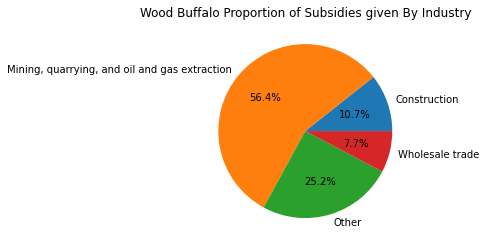

In [14]:
# Wood buffalo
temp = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'Level 1' and Region == 'Wood Buffalo'")
# Note that some values are supressed
temp = temp.dropna().groupby("Industry").sum().reset_index()
# Group smaller industries into 1
for i in range(len(temp)):
    if temp["Industry"][i] not in ["Mining, quarrying, and oil and gas extraction", "Construction", "Wholesale trade"]:
        temp["Industry"][i] = "Other"

temp = temp.groupby("Industry").sum().reset_index()

 # Plot
    
plt.pie(temp["Subsidy"], labels = temp["Industry"], autopct = '%1.1f%%')
plt.title("Wood Buffalo Proportion of Subsidies given By Industry")
#plt.savefig("WBSubByInd.png")
plt.show()

<ipython-input-15-782c88503c98>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2["Industry"][i] = "Other"


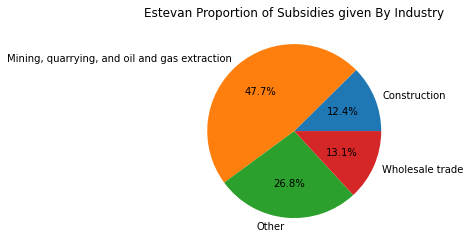

In [15]:
# Estevan
temp2 = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'Level 1' and Region == 'Estevan'")
# Note that some values are supressed
temp2 = temp2.dropna().groupby("Industry").sum().reset_index()

for i in range(len(temp2)):
    if temp2["Industry"][i] not in ["Mining, quarrying, and oil and gas extraction", "Construction", "Wholesale trade"]:
        temp2["Industry"][i] = "Other"

temp2 = temp2.groupby("Industry").sum().reset_index()

plt.pie(temp2["Subsidy"], labels = temp2["Industry"], autopct = '%1.1f%%')
plt.title("Estevan Proportion of Subsidies given By Industry")
#plt.savefig("ESubByInd.png")
plt.show()

<ipython-input-16-a769726040ba>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp3["Industry"][i] = "Other"


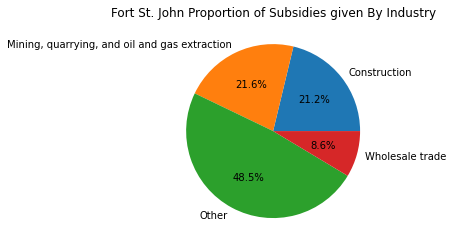

In [16]:
# Fort St. John
temp3 = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'Level 1' and Region == 'Fort St. John'")
# Note that some values are supressed
temp3 = temp3.dropna().groupby("Industry").sum().reset_index()

for i in range(len(temp3)):
    if temp3["Industry"][i] not in ["Mining, quarrying, and oil and gas extraction", "Construction", "Wholesale trade"]:
        temp3["Industry"][i] = "Other"

temp3 = temp3.groupby("Industry").sum().reset_index()

plt.pie(temp3["Subsidy"], labels = temp3["Industry"], autopct = '%1.1f%%')
plt.title("Fort St. John Proportion of Subsidies given By Industry")
#plt.savefig("FSJSubByInd.png")
plt.show()

For all three of these agglomerations, the most subsidized industries are all
- Mining, quarrying oil and gas
- Construction
- Wholesale Trade

All in that order. In these hard-hit, smaller agglomerations, the majority of subsidy money is going to these industries.

When we look at all ten of the hardest-hit agglomerations and metropolitan areas, we see that the most subsidized industry in Ontario and Quebec regions is uniformly manufacturing. In the praries and BC it is oil and gas or construction, and in Gander, NL it is transportation. 

In [17]:
temp6 = popByCity.query("StatEn == 'Count' and SexEn == 'Both sexes'")
temp6
temp5 = cews.query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'All industries'").groupby("Region").sum().reset_index()

temp6 = temp5.merge(temp6, how = "left", left_on = "Region", right_on = "GeoNameEn")

temp6["SubsidyPerPerson"] = temp6["Subsidy"] / temp6["AgeTot"]

temp6 = temp6.sort_values("SubsidyPerPerson").tail(15)

# Pull out the names of the ten most subsidized regions 
mostSubsidized = temp6["Region"]

# Find level 1 industry rows for towns in our most subsidized list
temp = cews[cews["Region"].isin(mostSubsidized)].query("GeoAggregation == 'CMA/CA' and IndustryAggregation == 'Level 1'")
temp = temp.groupby(["Region", "Industry"]).sum().reset_index()
# Finds the max subsidy given in each city
temp = temp[temp["Subsidy"] == temp.groupby("Region")["Subsidy"].transform(max)]

# Join the SubsidyPerPErson data from temp6
temp = temp6.filter(["Region", "SubsidyPerPerson"]).merge(temp, how = "left", on = "Region")

alt.Chart(temp, title = "Most Subsidized Industry in the Ten Most Subsidized CMA/CA's (per Resident)").mark_bar().encode(
    x = "SubsidyPerPerson",
    y = "Region",
    # Most subsidized industry
    color = "Industry"
)

alt.Chart(...)

Clearly there are some obvious Provincial differences that should be analyzed.

## The hardest hit industries in each Province

In [18]:
temp = cews.query("GeoAggregation == 'Province' and IndustryAggregation == 'Level 1'")
temp = temp.groupby(["Region", "Industry"]).sum().reset_index()

temp = temp[temp["Subsidy"] == temp.groupby("Region")["Subsidy"].transform(max)]

alt.Chart(temp).mark_bar().encode(
    x = "Subsidy",
    y = "Region",
    color = "Industry"
)

alt.Chart(...)

## Story 2: The largest Subsidies given to rural and urban census subdivisions

In [19]:
temp = cews.query("GeographicClassification == 'RURAL' and GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'").\
    groupby(["Region", "Industry"]).sum().sort_values("BusinessLocations").sort_values("Subsidy").tail(10).reset_index()

alt.Chart(temp, title = "10 largest subsidies Given to Rural Communities (CSD)").mark_bar().encode(
    x = "Subsidy",
    y = "Region",
    color = "Industry"
)

alt.Chart(...)

In [20]:
temp = cews.query("GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'").\
    groupby(["Region", "Industry"]).sum().sort_values("BusinessLocations").sort_values("Subsidy").tail(10).reset_index()

alt.Chart(temp, title = "10 largest subsidies Given to Urban Communities (CSD)").mark_bar().encode(
    x = "Subsidy",
    y = "Region",
    color = "Industry"
)

alt.Chart(...)

In [21]:
cews.query("GeoAggregation == 'Canada' and IndustryAggregation == 'All industries'").sum()

RegionCode_x                         TOTALTOTALTOTALTOTALTOTALTOTALTOTALTOTAL
Region                       CanadaCanadaCanadaCanadaCanadaCanadaCanadaCanada
GeographicClassification    Not applicableNot applicableNot applicableNot ...
CensusLevel                 Not applicableNot applicableNot applicableNot ...
IndustryCode                         TOTALTOTALTOTALTOTALTOTALTOTALTOTALTOTAL
Industry                    All IndustriesAll IndustriesAll IndustriesAll ...
BusinessLocations                                                 2.25860e+06
Subsidy                                                           5.56041e+10
SupportedEmployees                                                3.04894e+07
RehiredEmployees                                                       224675
GeoAggregation               CanadaCanadaCanadaCanadaCanadaCanadaCanadaCanada
IndustryAggregation         All industriesAll industriesAll industriesAll ...
ProvinceCode                                                    

### Rural Communities in Alberta were disproportionately effected.

In [22]:
temp = cews.query("GeographicClassification == 'RURAL' and GeoAggregation == 'CSD' and IndustryAggregation == 'All industries'")

temp = temp.groupby(["Region", "Province"]).sum().reset_index().sort_values("Subsidy")

alt.Chart(temp.tail(15), title = "15 Most Subsidized Rural CSD's").mark_bar().encode(
        alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "Subsidy",
    y = "Region"
)

alt.Chart(...)

## Urban communities are more evenly spread accross the country, with more representation in more populated provinces

In [23]:
temp = cews.query("GeographicClassification == 'URBAN' and GeoAggregation == 'CSD' and IndustryAggregation == 'All industries'")
temp[temp["Region"] == "Toronto"]
temp = temp.groupby(["Region", "Province"]).sum().reset_index().sort_values("Subsidy")

alt.Chart(temp.tail(15), title = "15 Most Subsidized Urban Communities").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "Subsidy",
    y = "Region"
)

alt.Chart(...)

### Story 3: Some census subdivisions recieved over \\$100,000 subsidies per permanent resident

In [24]:
# I'm not sure why, but theis dataset has multiple values corresponding to each region
# differentiated by a 2 letter code which isn't explained. It seems like the larger number
# more accurately corresponds to the value we expect.

popByCSD = pd.read_csv("more_data/popByCSD.csv")

# Get population of each CSD from table. There is some manipulation required since the table has annoying names
def extractCity(region):
    return region[0: region.find(' (')]

def extractProvince(region):
    return region[region.find('), ') + 3:]
popByCSD["Census Subdivision"] = popByCSD["Region"].apply(extractCity)
popByCSD["Province"] = popByCSD["Region"].apply(extractProvince)
# SOme regions have .. as population, which I don't knwo what it means. Not surveyed?
popByCSD = popByCSD[popByCSD["2020Population"] != ".."]
popByCSD["2020Population"] = popByCSD["2020Population"].str.replace(",", "", regex = False)
popByCSD["2020Population"] = pd.to_numeric(popByCSD["2020Population"])

popByCSD = popByCSD.groupby(["Census Subdivision", "Province"]).max().reset_index()
popByCSD.head()

FileNotFoundError: [Errno 2] No such file or directory: 'more_data/popByCSD.csv'

In [25]:
# Check for rural

temp = cews.query("GeographicClassification == 'RURAL' and GeoAggregation == 'CSD' and IndustryAggregation == 'All industries'")

temp = temp.groupby(["Region", "Province"]).sum().reset_index()

temp = temp.merge(popByCSD, how = "left", left_on = ["Region", "Province"], right_on = ["Census Subdivision", "Province"])
temp["AvgSupportedEmployees"] = temp["SupportedEmployees"] / 8
temp["SubsidyPerResident"] = temp["Subsidy"] / pd.to_numeric(temp["2020Population"])

KeyError: 'Census Subdivision'

In [216]:
# Some of these areas have reported 2020 populations of 0, but have many supported employees. My assumption would be that these
# are all industry towns with few permanent residents, but nearby businesses and work camps.
temp.sort_values("SubsidyPerResident", ascending = False).head(20)

,Region_x,Province,BusinessLocations,Subsidy,SupportedEmployees,RehiredEmployees,Census Subdivision,Region_y,2020Population,AvgSupportedEmployees,SubsidyPerResident
908,Kananaskis,Alberta,60.0,5233000.0,2940.0,5.0,Kananaskis,"Kananaskis (ID), Alberta",232.0,367.500,22556.034483
1982,Saint-Roch-Ouest,Quebec,95.0,5497000.0,2393.0,10.0,Saint-Roch-Ouest,"Saint-Roch-Ouest (MÉ), Quebec",282.0,299.125,19492.907801
175,Blacks Harbour,New Brunswick,40.0,12999000.0,5920.0,0.0,Blacks Harbour,"Blacks Harbour (VL), New Brunswick",916.0,740.000,14191.048035
877,Improvement District No. 9 Banff,Alberta,270.0,14752000.0,6619.0,55.0,Improvement District No. 9 Banff,"Improvement District No. 9 Banff (ID), Alberta",1080.0,827.375,13659.259259
743,Grand Falls,New Brunswick,675.0,12397000.0,7799.0,65.0,Grand Falls,"Grand Falls (P), New Brunswick",1070.0,974.875,11585.981308
358,Chauvin,Alberta,90.0,3785000.0,1591.0,5.0,Chauvin,"Chauvin (VL), Alberta",332.0,198.875,11400.602410
262,Cambridge 32,Nova Scotia,95.0,1411000.0,827.0,0.0,Cambridge 32,"Cambridge 32 (IRI), Nova Scotia",147.0,103.375,9598.639456
876,Improvement District No. 4 Waterton,Alberta,50.0,1030000.0,858.0,10.0,Improvement District No. 4 Waterton,"Improvement District No. 4 Waterton (ID), Alb...",109.0,107.250,9449.541284
199,Borden-Carleton,Prince Edward Island,210.0,6980000.0,3921.0,10.0,Borden-Carleton,"Borden-Carleton (T), Prince Edward Island",767.0,490.125,9100.391134
206,Boyle,Alberta,145.0,7456000.0,3674.0,10.0,Boyle,"Boyle (VL), Alberta",833.0,459.250,8950.780312


In [200]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2563 entries, 0 to 2562
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Region_x               2563 non-null   object 
 1   Province               2563 non-null   object 
 2   BusinessLocations      2563 non-null   float64
 3   Subsidy                2563 non-null   float64
 4   SupportedEmployees     2563 non-null   float64
 5   RehiredEmployees       2563 non-null   float64
 6   Census Subdivision     2507 non-null   object 
 7   Region_y               2507 non-null   object 
 8   2020Population         2507 non-null   float64
 9   AvgSupportedEmployees  2563 non-null   float64
 10  SubsidyPerResident     2506 non-null   float64
dtypes: float64(7), object(4)
memory usage: 240.3+ KB


In [217]:
# We can look only at CSD's with permanent populations greater than 1000, so the larger denominators stabalize the data somewhat

temp = temp[temp["2020Population"] > 1000].sort_values("SubsidyPerResident").tail(15)

alt.Chart(temp, title = "Subsidy Given Per Resident in the 15 Most Subsidized Rural CSDs with population > 1000 (per resident)").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "SubsidyPerResident",
    y = "Census Subdivision"
)

alt.Chart(...)

In [202]:
temp = cews.query("GeographicClassification == 'URBAN' and GeoAggregation == 'CSD' and IndustryAggregation == 'All industries'")

temp = temp.groupby(["Region", "Province"]).sum().reset_index().sort_values("Subsidy")

temp = temp.merge(popByCSD, how = "left", right_on = ["Census Subdivision", "Province"], left_on = ["Region", "Province"])
temp["AvgSupportedEmployees"] = temp["SupportedEmployees"] / 8
temp["SubsidyPerResident"] = temp["Subsidy"] / pd.to_numeric(temp["2020Population"])
#temp.sort_values("SubsidyPerResident", ascending = False).head(20)

In [203]:
temp = temp[temp["2020Population"] > 1000].sort_values("SubsidyPerResident").tail(15)

alt.Chart(temp, title = "Subsidy Given Per Resident in the 15 Most Subsidized Urban CSDs with population > 1000 (per resident)").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "SubsidyPerResident",
    y = "Census Subdivision"
)

alt.Chart(...)

On a per-resident basis, Quebec urban areas are disproportionately subsidized, and Alberta rural subdivisions are disproportionately subsidized.

In [204]:
temp.head(1)

,Region_x,Province,BusinessLocations,Subsidy,SupportedEmployees,RehiredEmployees,Census Subdivision,Region_y,2020Population,AvgSupportedEmployees,SubsidyPerResident
737,Pointe-Claire,Quebec,4060.0,128529000.0,74757.0,390.0,Pointe-Claire,"Pointe-Claire (V), Quebec",33698.0,9344.625,3814.143273


### Exploring the Most Subsidized Rural Community in Each Province

In [205]:
temp = cews.query("GeographicClassification == 'RURAL' and GeoAggregation == 'CSD' and IndustryAggregation == 'All industries'")

temp = temp.groupby(["Region", "Province"]).sum().reset_index().sort_values("Subsidy", ascending = False)

temp3 = pd.DataFrame({'Region': [], 'Province': [], 'BusinessLocations': [],
                     'Subsidy': [], 'SupportedEmployees': [], 'RehiredEmployees': []})

# Find the most subsidized CSD in each Province and append it to temp3
for prov in set(temp["Province"]):
    temp2 = temp[temp["Province"] == prov].reset_index()
    temp3 = temp3.append(temp2.iloc[temp2['Subsidy'].idxmax()])
    
temp3

,Region,Province,BusinessLocations,Subsidy,SupportedEmployees,RehiredEmployees,index
0,Mont-Tremblant,Quebec,1705.0,36275000.0,22236.0,185.0,1307.0
0,Iqaluit,Nunavut,350.0,23414000.0,9872.0,5.0,894.0
0,Caraquet,New Brunswick,680.0,13790000.0,6988.0,65.0,282.0
0,Selkirk,Manitoba,680.0,13176000.0,8665.0,30.0,2155.0
0,Borden-Carleton,Prince Edward Island,210.0,6980000.0,3921.0,10.0,199.0
0,Inuvik,Northwest Territories,220.0,8713000.0,3500.0,5.0,886.0
0,Whistler,British Columbia,2900.0,80301000.0,42782.0,400.0,2508.0
0,Haldimand County,Ontario,1925.0,32842000.0,19269.0,185.0,784.0
0,Kindersley,Saskatchewan,985.0,11908000.0,5958.0,105.0,941.0
0,Grande Prairie County No. 1,Alberta,3305.0,103666000.0,44036.0,225.0,752.0


In [206]:
alt.Chart(temp3, title = "Total Subsidies Given to the Most Subsidized Rural CSD in Each Province").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "Subsidy",
    y = "Region"
)

alt.Chart(...)

In [207]:
# Industry breakdown of subsidies and affected employees in the 
# most subsidized rural CSD of each province/territory

divisions = list(temp3["Region"])
charts = [0]*13
for div, i in zip(divisions, range(len(divisions))):
    temp = cews.query("GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'")
    temp = temp[temp["Region"] == div]
    prov = temp["Province"].iloc[0]
    charts[i] = alt.Chart(temp, title = f"Industries in {div}, {prov}").mark_bar().encode(
                    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors), legend = None),
                    y = "Industry",
                    x = "Subsidy",
                )

(charts[0]|charts[1]) & (charts[2]|charts[3]) & (charts[4]|charts[5]) &\
(charts[6]|charts[7]) & (charts[8]|charts[9]) & (charts[10]|charts[11])&\
(charts[12])

alt.VConcatChart(...)

In [208]:
charts = [0]*13
for div, i in zip(divisions, range(len(divisions))):
    temp = cews.query("GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'")
    temp = temp[temp["Region"] == div]
    prov = temp["Province"].iloc[0]
    charts[i] = alt.Chart(temp, title = f"Industries in {div}, {prov}").mark_bar().encode(
                    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors), legend = None),
                    y = "Industry",
                    x = "SupportedEmployees",
                )

(charts[0]|charts[1]) & (charts[2]|charts[3]) & (charts[4]|charts[5]) &\
(charts[6]|charts[7]) & (charts[8]|charts[9]) & (charts[10]|charts[11])&\
(charts[12])

alt.VConcatChart(...)

We see a few trends here. The largest subsidy in each of these regions is either food and accomidation, retail, manufacturing, or construction. Subdivisions which recieve large accomidation subsidies tend to also recieve large retail subsidies. We see that Whistler, Mont Tremblant, Clarenville, and Dawson are all renowned tourist areas, with large subsidies given in the food service and retail industries due to the loss of tourism due to Covid-19.

We can look at the same for urban CSDs

In [221]:
temp = cews.query("GeographicClassification == 'URBAN' and GeoAggregation == 'CSD' and IndustryAggregation == 'All industries'")

temp = temp.groupby(["Region", "Province"]).sum().reset_index().sort_values("Subsidy", ascending = False)

temp3 = pd.DataFrame({'Region': [], 'Province': [], 'BusinessLocations': [],
                     'Subsidy': [], 'SupportedEmployees': [], 'RehiredEmployees': []})

# Find the most subsidized CSD in each Province and append it to temp3
for prov in set(temp["Province"]):
    temp2 = temp[temp["Province"] == prov].reset_index()
    temp3 = temp3.append(temp2.iloc[temp2['Subsidy'].idxmax()])
    
temp3

,Region,Province,BusinessLocations,Subsidy,SupportedEmployees,RehiredEmployees,index
0,Montréal,Quebec,117070.0,3.558849e+09,1907631.0,12885.0,395.0
0,Saint John,New Brunswick,5920.0,1.850660e+08,93249.0,445.0,553.0
0,Winnipeg,Manitoba,40270.0,9.674450e+08,580463.0,3950.0,793.0
0,Charlottetown,Prince Edward Island,4410.0,7.495900e+07,49304.0,425.0,110.0
0,Yellowknife,Northwest Territories,1500.0,4.543300e+07,20041.0,135.0,801.0
0,Vancouver,British Columbia,67860.0,1.568579e+09,850570.0,7430.0,748.0
0,Toronto,Ontario,199360.0,5.431794e+09,2881962.0,20735.0,729.0
0,Saskatoon,Saskatchewan,18835.0,3.894580e+08,223953.0,1930.0,645.0
0,Calgary,Alberta,106690.0,3.427259e+09,1616499.0,10360.0,80.0
0,St. John's,Newfoundland and Labrador,9775.0,2.298210e+08,128243.0,835.0,685.0


In [223]:
alt.Chart(temp3, title = "Total Subsidies Given to the Most Subsidized Urban CSD in Each Province").mark_bar().encode(
    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors)),
    x = "Subsidy",
    y = "Region"
)

alt.Chart(...)

Note that Nunavut has no urban areas according to this classification

In [238]:

divisions = list(temp3["Region"])
charts = [0]*13
for div, i in zip(divisions, range(len(divisions))):
    temp = cews.query("GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'")
    temp = temp[temp["Region"] == div]
    prov = temp["Province"].iloc[0]
    charts[i] = alt.Chart(temp, title = f"Industries in {div}, {prov}").mark_bar().encode(
                    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors), legend = None),
                    y = "Industry",
                    x = "Subsidy",
                )

(charts[0]|charts[1]) & (charts[2]|charts[3]) & (charts[4]|charts[5]) &\
(charts[6]|charts[7]) & (charts[8]|charts[9]) & (charts[10]|charts[11])

alt.VConcatChart(...)

In [240]:
cews.query("GeoAggregation == 'Canada' and IndustryAggregation == 'Level 1'")["Industry"].drop_duplicates()

70943           Agriculture, forestry, fishing and hunting
70949        Mining, quarrying, and oil and gas extraction
70953                                            Utilities
70954                                         Construction
70958                                        Manufacturing
70980                                      Wholesale trade
70990                                         Retail trade
71003                       Transportation and warehousing
71015                  Information and cultural industries
71022                                Finance and insurance
71027                   Real estate and rental and leasing
71031      Professional, scientific and technical services
71032              Management of companies and enterprises
71033    Administrative and support, waste management a...
71036                                 Educational services
71037                    Health care and social assistance
71042                   Arts, entertainment and recreati

## Proportion of CSD's with industry as most subsidized

In [291]:
temp = cews.query("GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'")

temp = temp.groupby(["Region", "Province", "Industry"]).sum().reset_index().sort_values("Subsidy", ascending = False)
temp

temp3 = pd.DataFrame({'Region': [], 'Province': [], 'BusinessLocations': [],
                     'Subsidy': [], 'SupportedEmployees': [], 'RehiredEmployees': []})

# Find the most subsidized idustry in each CSD
for csd in set(temp["Region"]):
    temp2 = temp[temp["Region"] == csd].reset_index()
    temp3 = temp3.append(temp2.iloc[temp2['Subsidy'].idxmax()])
    
# Fiter for only the ones which recieved subsidies
temp3 = temp3[temp3["Subsidy"] > 0]

In [292]:
# Proportions of CSD's with each industry as most subsidized
temp2 = temp3.groupby("Industry").count()["Region"].reset_index()
alt.Chart(temp2, title = "Number of CSDs with each Industry as most subsidized").mark_bar().encode(
    alt.X("Region"),
    alt.Y("Industry"),
    alt.Color("Industry", legend = None)
)

alt.Chart(...)

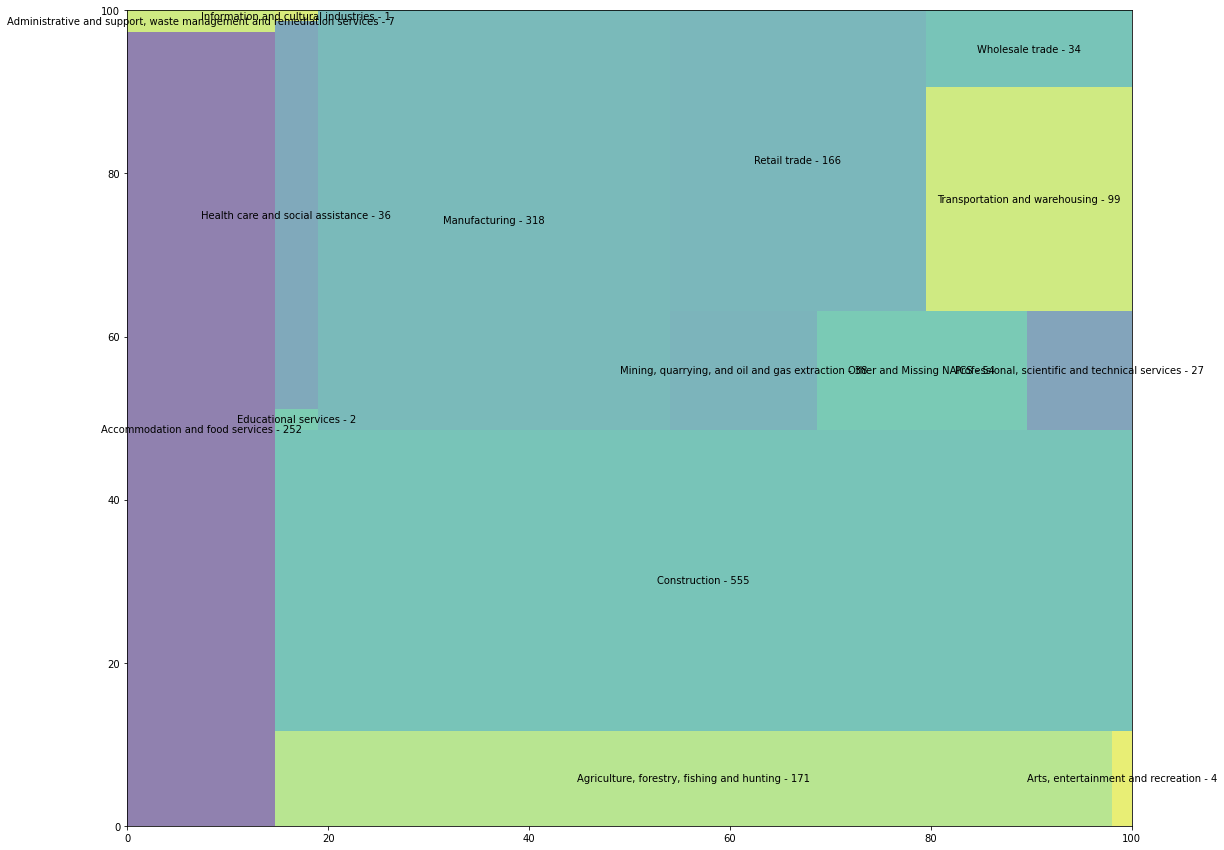

In [293]:
labs = [f"{industry} - {count}" for industry, count in zip(temp2["Industry"], temp2["Region"])]
plt.figure(figsize = (18,15))
squarify.plot(sizes = temp2.Region, label = labs, alpha = 0.6)
#plt.savefig("topIndustriesbyCSD.png")
plt.show()

## Examine the CSDs with peculiar industries as most subsidized

In [283]:
inds = list(temp2[temp2["Region"] < 5].Industry)
weirds = list(temp3[temp3["Industry"].isin(inds)].Region)

temp = cews.query("GeoAggregation == 'CSD' and IndustryAggregation == 'Level 1'")
temp = temp[temp["Region"].isin(weirds)].groupby(["Region", "Province", "Industry"]).sum().reset_index()
temp

,Region,Province,Industry,BusinessLocations,Subsidy,SupportedEmployees,RehiredEmployees
0,East Kootenay F,British Columbia,Accommodation and food services,40.0,649000.0,788.0,10.0
1,East Kootenay F,British Columbia,"Administrative and support, waste management a...",40.0,244000.0,134.0,0.0
2,East Kootenay F,British Columbia,"Agriculture, forestry, fishing and hunting",0.0,0.0,0.0,0.0
3,East Kootenay F,British Columbia,"Arts, entertainment and recreation",35.0,970000.0,712.0,10.0
4,East Kootenay F,British Columbia,Construction,70.0,595000.0,276.0,0.0
...,...,...,...,...,...,...,...
78,Tsawwassen,British Columbia,Information and cultural industries,20.0,0.0,0.0,0.0
79,Tsawwassen,British Columbia,Other and Missing NAICS,10.0,0.0,0.0,0.0
80,Tsawwassen,British Columbia,Retail trade,0.0,0.0,0.0,0.0
81,Tsawwassen,British Columbia,Transportation and warehousing,25.0,43000.0,20.0,5.0


In [287]:
charts = [0]*(len(weirds))
for div, i in zip(weirds, range(len(weirds))):
    temp2 = temp[temp["Region"] == div]
    prov = temp2["Province"].iloc[0]
    charts[i] = alt.Chart(temp2, title = f"Industries in {div}, {prov}").mark_bar().encode(
                    alt.Color("Province", scale = alt.Scale(domain = provinces, range = provColors), legend = None),
                    y = "Industry",
                    x = "Subsidy",
                )

(charts[0]|charts[1]) & (charts[2]|charts[3]) & (charts[4]|charts[5]) &\
(charts[6])

alt.VConcatChart(...)

We see that many of the peculiar CSDs didn't recieve subsidies in many industries.